In [7]:
pwd

'/home/ben/Documents/analysis_code/spectrum_analysis'

In [8]:
ls

116Cd_d,p_bite_1/                           Distribution Troubleshooting.ipynb
116Cd_d,p_bite_1_new/                       energy_xsection_writer.py
116Cd_d,p_bite_1_patrickbic/                feb_may_normalisation/
116Cd_d,t_bite_1/                           input/
116Cd_p,d_115Cd_39degrees_bite_1_peaks.txt  notebook.tex
116Cd_p,d_bite_1/                           output/
116Cd_p,d_bite_1_different_bic/             output_13_0.png
116Cd_p,d_bite_2/                           output_18_0.png
116Cd_p,d_bite_3/                           __pycache__/
angle_dependent_normalisation.ipynb         run_properties/
bic_correction.ods                          spectroscopic_checker.ipynb
Cross-section-checker.ipynb                 spectrum_classes.py


# Reading in Data

In [9]:
#glob gets filenames from the path.
#In this case I'm getting all of the run properties (BIC, zero channel counts,
#target thickness etc)
#and the peak data (from 'input' directory)

import glob

bite2ps = glob.glob('116Cd_p,d_bite_2/run_properties/*')
bite3ps = glob.glob('116Cd_p,d_bite_3/run_properties/*')
bite3pk = glob.glob('116Cd_p,d_bite_3/input/*')
bite2pk = glob.glob('116Cd_p,d_bite_2/input/*')
bite2pk

['116Cd_p,d_bite_2/input/116Cd_p,d_115Cd_39degrees_bite_2_peaks.pkl',
 '116Cd_p,d_bite_2/input/116Cd_p,d_115Cd_31degrees_bite_2_peaks.pkl',
 '116Cd_p,d_bite_2/input/116Cd_p,d_115Cd_26degrees_bite_2_peaks.pkl',
 '116Cd_p,d_bite_2/input/116Cd_p,d_115Cd_8degrees_bite_2_peaks.pkl',
 '116Cd_p,d_bite_2/input/116Cd_p,d_115Cd_17degrees_bite_2_peaks.pkl']

In [10]:
bite2ps

['116Cd_p,d_bite_2/run_properties/116Cd_p,d_115Cd_8degrees_bite_2_properties.csv',
 '116Cd_p,d_bite_2/run_properties/116Cd_p,d_115Cd_17degrees_bite_2_properties.csv',
 '116Cd_p,d_bite_2/run_properties/116Cd_p,d_115Cd_26degrees_bite_2_properties.csv',
 '116Cd_p,d_bite_2/run_properties/116Cd_p,d_115Cd_31degrees_bite_2_properties.csv',
 '116Cd_p,d_bite_2/run_properties/116Cd_p,d_115Cd_39degrees_bite_2_properties.csv',
 '116Cd_p,d_bite_2/run_properties/116Cd_p,d_115Cd_17degrees_bite_2_properties_2200.csv']

In [11]:
#read in data. Pandas is a data analysis tool in python which allows me to read in
#tables all at once and do operations on them
#In my code I do this as a loop and work out the cross-sections and write to file 
#within that loop
#Here I explicitly don't do this so I can rule out simply reading the
#files in the wrong order aas the problem

import pandas as pd

#I'm reading in all my run and peak data. Naming convention is angle, bite,
#then properties(ps) or peaks(pk)
a8_b3_ps = pd.read_table(bite3ps[0], sep = ',') #csvs so separation is a comma
a17_b3_ps = pd.read_table(bite3ps[1], sep = ',')
a26_b3_ps = pd.read_table(bite3ps[2], sep = ',')
a31_b3_ps = pd.read_table(bite3ps[3], sep = ',')
a39_b3_ps = pd.read_table(bite3ps[4], sep = ',')

a8_b2_ps = pd.read_table(bite2ps[0], sep = ',')
a17_b2_ps = pd.read_table(bite2ps[1], sep = ',')
a26_b2_ps = pd.read_table(bite2ps[2], sep = ',')
a31_b2_ps = pd.read_table(bite2ps[3], sep = ',')
a39_b2_ps = pd.read_table(bite2ps[4], sep = ',')

a8_b3_pk = pd.read_pickle(bite3pk[4])# pickle is a format that pandas can read
a17_b3_pk = pd.read_pickle(bite3pk[3])
a26_b3_pk = pd.read_pickle(bite3pk[2])
a31_b3_pk = pd.read_pickle(bite3pk[0])
a39_b3_pk = pd.read_pickle(bite3pk[1])

a8_b2_pk = pd.read_pickle(bite2pk[3])
a17_b2_pk = pd.read_pickle(bite2pk[4])
a26_b2_pk = pd.read_pickle(bite2pk[2])
a31_b2_pk = pd.read_pickle(bite2pk[1])
a39_b2_pk = pd.read_pickle(bite2pk[0])

a8_b3_ps # This shows what my properties file looks like

,TARGET_THICKNESS,THICKNESS_UNCERTAINTY,OMEGA,THETA,S1,S3,CURRENT_OFFSET,CURRENT_GRADIENT,RUN_TIME,FS,ZBEAM,ZTARGET,ATARGET,Ch1,e_Ch1,Rest,e_R,ISOTOPIC_PURITY
0,47.11,1.42,7.25,8,297139,1654,-9.300000e+10,0.976,544,0.000002,1,48,116,281,17,12790,114,0.97


# Define Functions to Calculate Cross-sections

In [26]:
#add column functions.
import math

def beam_offset(df): #The offset in the BCI, in number of particles over the run
    return df["CURRENT_OFFSET"] * df["RUN_TIME"]

#The number of particles in the beam if there was no BCI correction
def no_beam_uncorrected(df): 
    return ((df["S1"]-df["S3"]) * df["FS"])/(df["ZBEAM"]*1.61e-19*1000)

#The number of particles in the beam, applying the BCI correction
def no_beam(uncorrected, offset, df):
    return uncorrected * float(df["CURRENT_GRADIENT"]) + offset

def snobeam(df): #The error in this
    return ((math.sqrt(df["S1"])-math.sqrt(df["S3"]) * df["FS"])/(df["ZBEAM"]*1.61e-19*1000))

def no_target(df): #Number of atoms in the target per millibarn
    return df["TARGET_THICKNESS"]/(df["ATARGET"]*1.661e-18)

def sno_target(df): #The uncertainty in this
    return df["THICKNESS_UNCERTAINTY"]/(df["ATARGET"]*1.661e-18)

def efficiency(df): #Zero-channel correction
    return df["Rest"]/(df["Rest"] + df["Ch1"])

def seff(df, eff): #error in this
    return eff * math.sqrt((df["Rest"]/df["e_R"])**2+((math.sqrt(df["e_Ch1"]
           **2+df["e_R"]**2))/(df["Ch1"] + df["Rest"]))**2)

#def cross(peak, notarget, nobeam, omega, purity, eff): #Cross-section calculator
#    return float((1e27*peak["AREA"])/(notarget*nobeam*(omega/1000)*purity*eff))

# Ruling out the zero-channel correction as the culprit

In [87]:
float(efficiency(a17_b3_ps))

0.9642381755257787

In [88]:
float(efficiency(a17_b2_ps))

0.9938793848866584

Between the 17 degree bite 2 and 3 runs, there is a ~3% difference in efficiency, meaning this is
likely not to blame for the discrepancy

# Ruling out the BIC correction

In [89]:
float(beam_offset(a17_b3_ps))

-49383000000000.0

In [90]:
float(beam_offset(a17_b2_ps))

-66030000000000.0

So there's a big difference in the raw beam offsets between bite 2 and 3, but can it cause the factor of 2 difference?

In [91]:
#Work out distributions with the BIC correction applied and without it.
#I do this for the 2113keV state, which is l = 2 in bite 3 and l = 0 in bite 2
#This is for both bites also

#numpy contains good array objects 
import numpy as np

#initialise arrays for bite 2 and 3 distributions with BIC corrections applied
bite_2_dist = np.zeros(5)
bite_3_dist = np.zeros(5)


#bite 2
df = a8_b2_ps
pk = a8_b2_pk.loc[39]

xs = cross(pk, float(no_target(df)), no_beam(float(no_beam_uncorrected(df)),
float(beam_offset(df)), df), float(df["OMEGA"]), 0.97, float(efficiency(df)))

bite_2_dist[0] = xs


df = a17_b2_ps
pk = a17_b2_pk.loc[39]

xs = cross(pk, float(no_target(df)), no_beam(float(no_beam_uncorrected(df)), 
float(beam_offset(df)), df), float(df["OMEGA"]), 0.97, float(efficiency(df)))

bite_2_dist[1] = xs


df = a26_b2_ps
pk = a26_b2_pk.loc[39]

xs = cross(pk, float(no_target(df)), no_beam(float(no_beam_uncorrected(df)),
float(beam_offset(df)), df), float(df["OMEGA"]), 0.97, float(efficiency(df)))

bite_2_dist[2] = xs


df = a31_b2_ps
pk = a31_b2_pk.loc[39]

xs = cross(pk, float(no_target(df)), no_beam(float(no_beam_uncorrected(df)),
float(beam_offset(df)), df), float(df["OMEGA"]), 0.97, float(efficiency(df)))

bite_2_dist[3] = xs


df = a39_b2_ps
pk = a39_b2_pk.loc[39]

xs = cross(pk, float(no_target(df)), no_beam(float(no_beam_uncorrected(df)),
float(beam_offset(df)), df), float(df["OMEGA"]), 0.97, float(efficiency(df)))

bite_2_dist[4] = xs


#bite 3
df = a8_b3_ps
pk = a8_b3_pk.loc[5]

xs = cross(pk, float(no_target(df)), no_beam(float(no_beam_uncorrected(df)),
float(beam_offset(df)), df), float(df["OMEGA"]), 0.97, float(efficiency(df)))

bite_3_dist[0] = xs


df = a17_b3_ps
pk = a17_b3_pk.loc[5]

xs = cross(pk, float(no_target(df)), no_beam(float(no_beam_uncorrected(df)),
float(beam_offset(df)), df), float(df["OMEGA"]), 0.97, float(efficiency(df)))

bite_3_dist[1] = xs


df = a26_b3_ps
pk = a26_b3_pk.loc[5]

xs = cross(pk, float(no_target(df)), no_beam(float(no_beam_uncorrected(df)),
float(beam_offset(df)), df), float(df["OMEGA"]), 0.97, float(efficiency(df)))

bite_3_dist[2] = xs


df = a31_b3_ps
pk = a31_b3_pk.loc[5]

xs = cross(pk, float(no_target(df)), no_beam(float(no_beam_uncorrected(df)),
float(beam_offset(df)), df), float(df["OMEGA"]), 0.97, float(efficiency(df)))

bite_3_dist[3] = xs


df = a39_b3_ps
pk = a39_b3_pk.loc[5]

xs = cross(pk, float(no_target(df)), no_beam(float(no_beam_uncorrected(df)),
float(beam_offset(df)), df), float(df["OMEGA"]), 0.97, float(efficiency(df)))

bite_3_dist[4] = xs

In [99]:
#no bic, same again
#You can see I use the uncorrected number in the beam instead of the corrected in the cross-section arguments

bite_2_no_bic = np.zeros(5)
bite_3_no_bic = np.zeros(5)

df = a8_b2_ps
pk = a8_b2_pk.loc[39]
xs = cross(pk, float(no_target(df)), float(no_beam_uncorrected(df)),
           float(df["OMEGA"]), 0.97, float(efficiency(df)))
bite_2_no_bic[0] = xs

df = a17_b2_ps
pk = a17_b2_pk.loc[39]
xs = cross(pk, float(no_target(df)), float(no_beam_uncorrected(df)),
           float(df["OMEGA"]), 0.97, float(efficiency(df)))
bite_2_no_bic[1] = xs

df = a26_b2_ps
pk = a26_b2_pk.loc[39]
xs = cross(pk, float(no_target(df)), float(no_beam_uncorrected(df)),
           float(df["OMEGA"]), 0.97, float(efficiency(df)))
bite_2_no_bic[2] = xs

df = a31_b2_ps
pk = a31_b2_pk.loc[39]
xs = cross(pk, float(no_target(df)), float(no_beam_uncorrected(df)),
           float(df["OMEGA"]), 0.97, float(efficiency(df)))
bite_2_no_bic[3] = xs

df = a39_b2_ps
pk = a39_b2_pk.loc[39]
xs = cross(pk, float(no_target(df)), float(no_beam_uncorrected(df)),
           float(df["OMEGA"]), 0.97, float(efficiency(df)))
bite_2_no_bic[4] = xs



df = a8_b3_ps
pk = a8_b3_pk.loc[5]
xs = cross(pk, float(no_target(df)), float(no_beam_uncorrected(df)),
           float(df["OMEGA"]), 0.97, float(efficiency(df)))
bite_3_no_bic[0] = xs

df = a17_b3_ps
pk = a17_b3_pk.loc[5]
xs = cross(pk, float(no_target(df)), float(no_beam_uncorrected(df)),
           float(df["OMEGA"]), 0.97, float(efficiency(df)))
bite_3_no_bic[1] = xs

df = a26_b3_ps
pk = a26_b3_pk.loc[5]
xs = cross(pk, float(no_target(df)), float(no_beam_uncorrected(df)),
           float(df["OMEGA"]), 0.97, float(efficiency(df)))
bite_3_no_bic[2] = xs

df = a31_b3_ps
pk = a31_b3_pk.loc[5]
xs = cross(pk, float(no_target(df)), float(no_beam_uncorrected(df)),
           float(df["OMEGA"]), 0.97, float(efficiency(df)))
bite_3_no_bic[3] = xs

df = a39_b3_ps
pk = a39_b3_pk.loc[5]
xs = cross(pk, float(no_target(df)), float(no_beam_uncorrected(df)),
           float(df["OMEGA"]), 0.97, float(efficiency(df)))
bite_3_no_bic[4] = xs

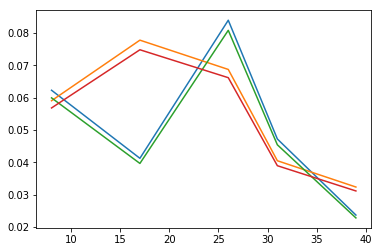

In [100]:
#Now to plot the distributions

#Plotting package
import matplotlib.pyplot as plt
%matplotlib inline

#Set the agles and do the plots
angles = np.array([8,17,26,31,39])
plt.plot(angles, bite_2_dist)
plt.plot(angles,bite_3_dist)

plt.plot(angles, bite_2_no_bic)
plt.plot(angles, bite_3_no_bic)

plt.show()

Whether the BIC correction is there or not is a small effect

In [94]:
print(bite_2_dist/bite_3_dist)

[1.05489447 0.53030483 1.22136366 1.16589028 0.73218368]


# Checking the Fits and Whether I've Mislabeled my Files

In [28]:
#not efficiency - numbers too similar
#not bic - effect isn't large enough
#not reading in files at this stage - done it manually here
#not bad properties input because it's only the scalers left not tested,
#and they match the mbslog
import numpy as np

#things not yet ruled out
#files labelled as wrong angle
#bad fit
#next check the relative areas of peaks
raw_areas_2 = np.zeros(5)
raw_areas_3 = np.zeros(5)

norm_areas_2 = np.zeros(5)
norm_areas_3 = np.zeros(5)

#Here I'm reading the yields normalised by the run time to check if
#the same pattern is seen in the raw data
norm_areas_2[0] = a8_b2_pk.loc[39]["AREA"]/float(a8_b2_ps['RUN_TIME'])
norm_areas_2[1] = a17_b2_pk.loc[39]["AREA"]/float(a17_b2_ps['RUN_TIME'])
norm_areas_2[2] = a26_b2_pk.loc[39]["AREA"]/float(a17_b2_ps['RUN_TIME'])
norm_areas_2[3] = a31_b2_pk.loc[39]["AREA"]/float(a17_b2_ps['RUN_TIME'])
norm_areas_2[4] = a39_b2_pk.loc[39]["AREA"]/float(a17_b2_ps['RUN_TIME'])

norm_areas_3[0] = a8_b3_pk.loc[5]["AREA"]/float(a8_b3_ps['RUN_TIME'])
norm_areas_3[1] = a17_b3_pk.loc[5]["AREA"]/float(a17_b3_ps['RUN_TIME'])
norm_areas_3[2] = a26_b3_pk.loc[5]["AREA"]/float(a26_b3_ps['RUN_TIME'])
norm_areas_3[3] = a31_b3_pk.loc[5]["AREA"]/float(a31_b3_ps['RUN_TIME'])
norm_areas_3[4] = a39_b3_pk.loc[5]["AREA"]/float(a39_b3_ps['RUN_TIME'])

#Here I'm extracting the raw data so I can compare it to the raw data
#I've screenshotted from doing the fit
#This makes sure I'm reading in the right data!
raw_areas_2[0] = a8_b2_pk.loc[39]["AREA"]
raw_areas_2[1] = a17_b2_pk.loc[39]["AREA"]
raw_areas_2[2] = a26_b2_pk.loc[39]["AREA"]
raw_areas_2[3] = a31_b2_pk.loc[39]["AREA"]
raw_areas_2[4] = a39_b2_pk.loc[39]["AREA"]

raw_areas_3[0] = a8_b3_pk.loc[5]["AREA"]
raw_areas_3[1] = a17_b3_pk.loc[5]["AREA"]
raw_areas_3[2] = a26_b3_pk.loc[5]["AREA"]
raw_areas_3[3] = a31_b3_pk.loc[5]["AREA"]
raw_areas_3[4] = a39_b3_pk.loc[5]["AREA"]

print(raw_areas_2)
print(raw_areas_3)

[ 376.  600. 1088.  608.  349.]
[351. 834. 953. 538. 632.]


In [119]:
#area/time normalisation
(norm_areas_2/norm_areas_3)


array([1.06925952, 0.53804843, 0.99372478, 1.01073355, 0.70310216])

In [116]:
#so those are consistently inconsistent, so it must be something before getting the
#areas
#which means either the areas here are mismatched to the raw data or the fit is bad
#areas match (see overleaf), therefore bad fit.
#however
(424/969) / (351/834) #The first bit are the raw areas for my new fit
#the ratios of the 8 and 17 degree measurements are the same for my new fit.

1.0396831697141296

In [1]:
#in summary, I have no idea

In [12]:
a17_b2_ps

,TARGET_THICKNESS,THICKNESS_UNCERTAINTY,OMEGA,THETA,S1,S3,CURRENT_OFFSET,CURRENT_GRADIENT,RUN_TIME,FS,ZBEAM,ZTARGET,ATARGET,Ch1,e_Ch1,Rest,e_R,ISOTOPIC_PURITY
0,47.11,1.42,14.03,17,371505,3374,-9.300000e+10,0.976,710,0.000002,1,48,116,361,19,58620,242,0.97


In [20]:
p_2200 = pd.read_table('116Cd_p,d_bite_3/run_properties/116Cd_p,d_115Cd_17degrees_bite_3_properties_2200.csv', sep = ',')

In [33]:
p_2200

,TARGET_THICKNESS,THICKNESS_UNCERTAINTY,OMEGA,THETA,S1,S3,CURRENT_OFFSET,CURRENT_GRADIENT,RUN_TIME,FS,ZBEAM,ZTARGET,ATARGET,Ch1,e_Ch1,Rest,e_R,ISOTOPIC_PURITY
0,47.11,1.42,14.03,17,170419,1596,-9.300000e+10,0.976,321,0.000002,1,48,116,271,16,13414,117,0.97


In [34]:
norm_area_2200 = 518/no_beam_uncorrected(p_2200)
norm_area_2100 = raw_areas_3[1]/no_beam_uncorrected(a17_b3_ps)
norm_area_1500 = raw_areas_2[1]/no_beam_uncorrected(a17_b2_ps)

In [35]:
norm_area_2200

0    2.469983e-13
dtype: float64

In [36]:
norm_area_2100

0    2.400880e-13
dtype: float64

In [37]:
norm_area_1500

0    1.312033e-13
dtype: float64